File Structure of DeepFake folder




------> TRAIN ---> FAKE
              --->REAL

-----> TEST ---> FAKE
            --->REAL

-----> project.ipynb                      
-----> project.zip

----> Test_Info.csv # Program will create run the cells
                                    
-----> my_model_1.h5 # model is saved here

In [104]:
# from google.colab import drive
# drive.mount('/content/drive')

In [105]:
# # for unzipping the zip file run this
# !unzip '/content/drive/MyDrive/Deepfake/TRAIN.zip' -d "/content/drive/MyDrive/Deepfake/"

## Building a deepfake image detection model which is capable of classifying image into two categories Ai-Genrated or Real image using TensorFlow

# Problem Definition
* The model is used for detection of deepfake or Ai-generated images that
  are now widly used for spreading hate speech and fake news.

# Data
* We are using Kaggle data  uploaded on the drive and will also upload     zip file on github  <i>refer https://github.com/vrmaverick/DeepFake_Detector </i>

# Evaluation

* Prediction Probalities should be more than 90% which is this projects goal to acheive

# Features

* Few key information abot features as the project is based on image classification which are unstructured, Thus there is no such distinctive feature but the data is divide into 3 parts . Testing,Training and Validation. and the model will be a binary classifier

In [106]:
# Importing all required tools
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.layers import Activation, Dense
from tensorflow.keras.models import load_model


# For Data Structuring
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# File Handling
import os

# For image processing
from matplotlib.pyplot import imread



In [107]:
print("TF Version",tf.__version__)
print("TF hub version :",hub.__version__)

TF Version 2.13.0
TF hub version : 0.16.1


# Checking for GPU accessibility
Can change runtime type if needed on  google collab


In [108]:
print("GPU available"if tf.config.list_physical_devices("GPU")else "Not Available")

Not Available


# Defining all the Functions that are used in the notebook further

In [109]:
# Generating file paths for images
def paths(p):
  """
  Navigate through Drive paths to access files from a particular folder
  takes one args

  """
  # Specify the folder path within your Google Drive
  folder_path = p
  # List files in the folder
  file_paths = []
  file_name = []
  for root, dirs, files in os.walk(folder_path):
      for file in files:
          file_paths.append(os.path.join(root, file))
          file_name.append(file)
          # print(f"File Path: {os.path.join(root, file)}")
  return file_paths,file_name


IMG_SIZE = 224
# Image Preprocessing
def process_image(ImagePath,img_size= IMG_SIZE):
  """
  Take image file path and convert image into tensors

  """
  # Read the image file
  image = tf.io.read_file(ImagePath)

  #Turning .jpg or jpeg into tensors (R,G,B)
  image = tf.image.decode_jpeg(image,channels = 3) #(R,G,B)

  # Normalizing the image by converting range 0 - 255 to 0 - 1
  image = tf.image.convert_image_dtype(image,tf.float32)

  # Resize the image to (224,224)
  image = tf.image.resize(image,size=[img_size,img_size])


  return image


# Create a simple function to return a tuple (image, label)
def get_tupple(image_path, label):
  """
  Takes an image file path name and the assosciated label,
  processes the image and reutrns a typle of (image, label).
  """
  image = process_image(image_path)
  return image, label



BATCH_SIZE = 32
# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_tupple).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
    data = data.map(get_tupple)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch



def visualize_25_images(image,labels):
  """
  Displays 25 images from a batch with labels

  """
  plt.figure(figsize=(10,10))
  for i in range(25):
    ax= plt.subplot(5,5,i+1)# row,column,index
    plt.imshow(image[i])
    plt.title(unique[labels[i].argmax()])
    plt.axis(plt.axis("off"))


# Getting our data ready

*Turning our images to tensors or numerical format*

To check if image exists on that path run the cell below else one may skip it

In [110]:
# !ls '/content/drive/MyDrive/Deepfake/TRAIN/FAKE'

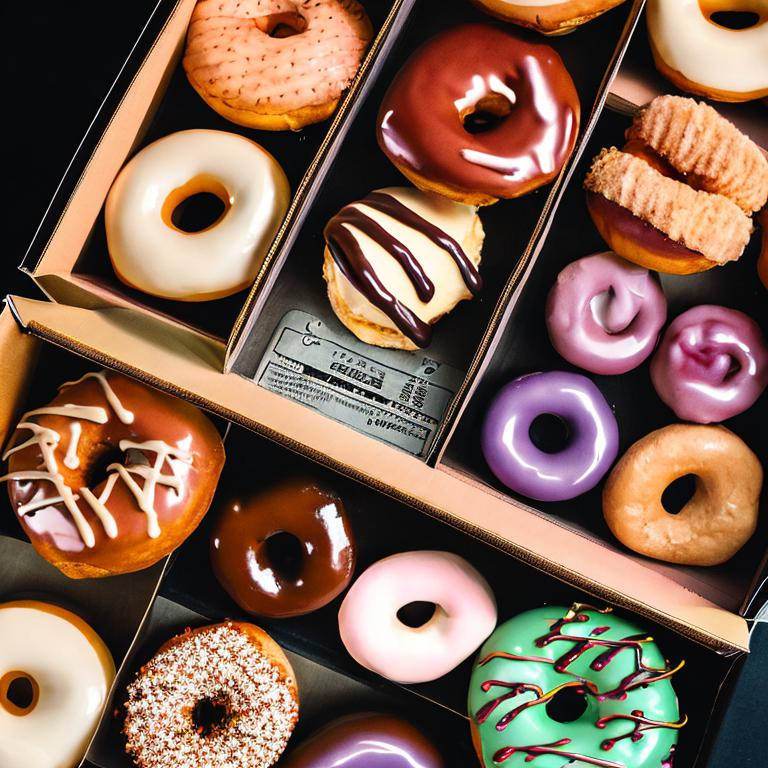

In [111]:
# Can be used for displaying images
from IPython.display import Image
Image('C://Users/Shreyas/Desktop/Deepfake/TRAIN/FAKE/000000580579.jpg')

# Getting image paths and labels

****************************************************************************

## *Skip Execution if already Done*......................................

In [112]:
# Accessing File paths of Ai Generated images which will be used for training
file_paths,file_name = paths('C://Users/Shreyas/Desktop/Deepfake/TRAIN/FAKE')

In [113]:
len(file_paths)

10000

In [114]:
len(file_name)

10000

In [115]:
# Creating a DataFrame for Convinience
df = pd.DataFrame(file_name, columns=['Image'])
df['Path']= file_paths
df['Class']='Fake'
df['Target']=0
df.head()

,Image,Path,Class,Target
0,000000004970.jpg,C://Users/Shreyas/Desktop/Deepfake/TRAIN/FAKE\...,Fake,0
1,000000005032.jpg,C://Users/Shreyas/Desktop/Deepfake/TRAIN/FAKE\...,Fake,0
2,000000005033.jpg,C://Users/Shreyas/Desktop/Deepfake/TRAIN/FAKE\...,Fake,0
3,000000005046.jpg,C://Users/Shreyas/Desktop/Deepfake/TRAIN/FAKE\...,Fake,0
4,000000005076.jpg,C://Users/Shreyas/Desktop/Deepfake/TRAIN/FAKE\...,Fake,0


In [116]:
# Accessing File paths of Real images which will be used for training
file_paths,file_name = paths('C://Users/Shreyas/Desktop/Deepfake/TRAIN/REAL')


In [117]:
print(len(file_name))
new_data = pd.DataFrame(file_name, columns=['Image'])
new_data['Path'] = file_paths
new_data['Class'] = 'Real'
new_data['Target'] = '1'
resulting_data = pd.concat([df, new_data], ignore_index=True)
del new_data
resulting_data

10000


,Image,Path,Class,Target
0,000000004970.jpg,C://Users/Shreyas/Desktop/Deepfake/TRAIN/FAKE\...,Fake,0
1,000000005032.jpg,C://Users/Shreyas/Desktop/Deepfake/TRAIN/FAKE\...,Fake,0
2,000000005033.jpg,C://Users/Shreyas/Desktop/Deepfake/TRAIN/FAKE\...,Fake,0
3,000000005046.jpg,C://Users/Shreyas/Desktop/Deepfake/TRAIN/FAKE\...,Fake,0
4,000000005076.jpg,C://Users/Shreyas/Desktop/Deepfake/TRAIN/FAKE\...,Fake,0
...,...,...,...,...
19995,000000581409.jpg,C://Users/Shreyas/Desktop/Deepfake/TRAIN/REAL\...,Real,1
19996,000000581481.jpg,C://Users/Shreyas/Desktop/Deepfake/TRAIN/REAL\...,Real,1
19997,000000581542.jpg,C://Users/Shreyas/Desktop/Deepfake/TRAIN/REAL\...,Real,1
19998,000000581766.jpg,C://Users/Shreyas/Desktop/Deepfake/TRAIN/REAL\...,Real,1


In [118]:

resulting_data['Class'].value_counts()
# resulting_data.to_csv('//content/drive/MyDrive/Deepfake/Test_Info.csv', index=False)

Fake    10000
Real    10000
Name: Class, dtype: int64

## Start Execution from below to save time no need to redo *****************

****************************************************************************

In [119]:
# resulting_data.to_csv('//content/drive/MyDrive/Deepfake/Test_Info.csv', index=False)
resulting_data = pd.read_csv('C://Users/Shreyas/Desktop/Deepfake/Test_Info.csv')
resulting_data

,Image,Path,Class,Target
0,000000004970.jpg,C://Users/Shreyas/Desktop/Deepfake/TRAIN/FAKE\...,Fake,0
1,000000005032.jpg,C://Users/Shreyas/Desktop/Deepfake/TRAIN/FAKE\...,Fake,0
2,000000005033.jpg,C://Users/Shreyas/Desktop/Deepfake/TRAIN/FAKE\...,Fake,0
3,000000005046.jpg,C://Users/Shreyas/Desktop/Deepfake/TRAIN/FAKE\...,Fake,0
4,000000005076.jpg,C://Users/Shreyas/Desktop/Deepfake/TRAIN/FAKE\...,Fake,0
...,...,...,...,...
19995,000000581409.jpg,C://Users/Shreyas/Desktop/Deepfake/TRAIN/REAL\...,Real,1
19996,000000581481.jpg,C://Users/Shreyas/Desktop/Deepfake/TRAIN/REAL\...,Real,1
19997,000000581542.jpg,C://Users/Shreyas/Desktop/Deepfake/TRAIN/REAL\...,Real,1
19998,000000581766.jpg,C://Users/Shreyas/Desktop/Deepfake/TRAIN/REAL\...,Real,1


In [120]:
# resulting_data['Target']=

In [121]:
# Shuffling data
resulting_data = resulting_data.sample(frac=1).reset_index(drop=True)

# Categorigal labels to tensors

In [122]:
labels = resulting_data['Target'].to_numpy()

In [123]:
labels

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [124]:
# len(labels)
unique = np.unique(labels)
unique

array([0, 1], dtype=int64)

Turning Labels into boolean or numeric form

In [125]:
bool_labels = [label == unique for label in labels]
bool_labels[:10]

[array([ True, False]),
 array([False,  True]),
 array([ True, False]),
 array([ True, False]),
 array([False,  True]),
 array([ True, False]),
 array([ True, False]),
 array([ True, False]),
 array([False,  True]),
 array([ True, False])]

In [126]:
len(bool_labels) #just for verification

20000

In [127]:
# Converting bool to Tensors
print("Binary Matrix = [fake,real]")
print(labels[11000])
print(bool_labels[11000].astype(int)) # as we have only two classes


Binary Matrix = [fake,real]
1
[0 1]


# To reduce Time between Expirimentation we will take help of sampling 1000 images first to get good idea of the parameters

So we will start with 1000 images

In [128]:
# Number of images for expirimenting
NUM_IMAGES = 20000 #@param {type:"slider",min:100,max:20000}

# Modelling

Dividing the Dataset into 2 sets Training and Validation Datasets respectively

In [129]:
df = pd.read_csv('C://Users/Shreyas/Desktop/Deepfake/Test_Info.csv')
df

,Image,Path,Class,Target
0,000000004970.jpg,C://Users/Shreyas/Desktop/Deepfake/TRAIN/FAKE\...,Fake,0
1,000000005032.jpg,C://Users/Shreyas/Desktop/Deepfake/TRAIN/FAKE\...,Fake,0
2,000000005033.jpg,C://Users/Shreyas/Desktop/Deepfake/TRAIN/FAKE\...,Fake,0
3,000000005046.jpg,C://Users/Shreyas/Desktop/Deepfake/TRAIN/FAKE\...,Fake,0
4,000000005076.jpg,C://Users/Shreyas/Desktop/Deepfake/TRAIN/FAKE\...,Fake,0
...,...,...,...,...
19995,000000581409.jpg,C://Users/Shreyas/Desktop/Deepfake/TRAIN/REAL\...,Real,1
19996,000000581481.jpg,C://Users/Shreyas/Desktop/Deepfake/TRAIN/REAL\...,Real,1
19997,000000581542.jpg,C://Users/Shreyas/Desktop/Deepfake/TRAIN/REAL\...,Real,1
19998,000000581766.jpg,C://Users/Shreyas/Desktop/Deepfake/TRAIN/REAL\...,Real,1


In [130]:
X = resulting_data['Path'].to_numpy()
print(X[:10],"Length :",len(X))

['C://Users/Shreyas/Desktop/Deepfake/TRAIN/FAKE\\000000285686.jpg'
 'C://Users/Shreyas/Desktop/Deepfake/TRAIN/REAL\\000000463342.jpg'
 'C://Users/Shreyas/Desktop/Deepfake/TRAIN/FAKE\\000000578119.jpg'
 'C://Users/Shreyas/Desktop/Deepfake/TRAIN/FAKE\\000000054723.jpg'
 'C://Users/Shreyas/Desktop/Deepfake/TRAIN/REAL\\000000103404.jpg'
 'C://Users/Shreyas/Desktop/Deepfake/TRAIN/FAKE\\000000264737.jpg'
 'C://Users/Shreyas/Desktop/Deepfake/TRAIN/FAKE\\000000033315.jpg'
 'C://Users/Shreyas/Desktop/Deepfake/TRAIN/FAKE\\000000295688.jpg'
 'C://Users/Shreyas/Desktop/Deepfake/TRAIN/REAL\\000000053503.jpg'
 'C://Users/Shreyas/Desktop/Deepfake/TRAIN/FAKE\\000000580681.jpg'] Length : 20000


In [131]:
# Y = bool_labels
Y = resulting_data['Target'].to_numpy()
print(Y[:10],"Length :",len(Y))

[0 1 0 0 1 0 0 0 1 0] Length : 20000


In [132]:
X_train,X_val,Y_train,Y_val = train_test_split(X[:NUM_IMAGES],Y[:NUM_IMAGES],test_size=0.2,random_state=8) # Good For Expirimenting Faster Results
print(f'Xtrain length ={len(X_train)} ,Ytrain length ={len(Y_train)} ,Xval length ={len(X_val)} ,Yval length ={len(Y_val)}')

Xtrain length =16000 ,Ytrain length =16000 ,Xval length =4000 ,Yval length =4000


## Preprocessing images : Turning Images to tensors

Preprocess our images into tensors we are going to write a function so it can be reused

1. Take a image filepath as inputs
2. Use tensorflow to read file and save it to variable `image`
3. Turn `image` into tensors (jpg)
4. Normalize image pixels representation between 0 and 1
5. Resize the image to shape (224,224)
6. Return the modified image




***************************************************************************


 Optional : before lets see how to conver images in numpy arrays and image analysis

In [133]:
image = imread(X[4]) # Converts img to nupy array
print(image.shape) # Aspect ratio with colur lane
print(f'Minimum and Maximum value of a pixel ({image.max()},{image.min()})')

(768, 768, 3)
Minimum and Maximum value of a pixel (255,0)


In [134]:
# Converting array to tensor for faster computation
tf.constant(image)[:1]

<tf.Tensor: shape=(1, 768, 3), dtype=uint8, numpy=
array([[[12, 17, 11],
        [13, 18, 12],
        [16, 21, 15],
        ...,
        [27, 26, 21],
        [25, 24, 19],
        [23, 22, 17]]], dtype=uint8)>

***************************************************************************

# Lets Combine Tensors to Batches for faster processing

Using batch size is 32  as Yann LeCun stated
https://twitter.com/ylecun/status/989610208497360896


Why to turn data into batches??
Because if we are processing 10,000 images then they might not fall into 8 GB Ram or memory

In order if we want to use Tensorflow effectively we will require

We need Tensor Tupples `(image,labels)`

In [135]:
IMG_SIZE = 224 # image size (224,224) is recomended


In [136]:
get_tupple(X[10],Y[10])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.01260504, 0.01260504, 0.01260504],
         [0.01206483, 0.01206483, 0.01206483],
         [0.00812325, 0.00812325, 0.00812325],
         ...,
         [0.04011596, 0.1563026 , 0.14761892],
         [0.04703906, 0.15266107, 0.15210058],
         [0.04929976, 0.14107648, 0.14621846]],
 
        [[0.00978391, 0.00978391, 0.00978391],
         [0.01406563, 0.01406563, 0.01406563],
         [0.00784314, 0.00784314, 0.00784314],
         ...,
         [0.01708684, 0.08673473, 0.07246894],
         [0.01708684, 0.08151262, 0.07014796],
         [0.01762707, 0.07028814, 0.0632453 ]],
 
        [[0.0114846 , 0.0114846 , 0.0114846 ],
         [0.01176471, 0.01176471, 0.01176471],
         [0.00784314, 0.00784314, 0.00784314],
         ...,
         [0.0115046 , 0.03447379, 0.02691076],
         [0.00522222, 0.02559011, 0.01932773],
         [0.00812325, 0.0232493 , 0.01932773]],
 
        ...,
 
        [[0.        , 0.        

In [137]:
train_data = create_data_batches(X_train,y=Y_train)
Val_data = create_data_batches(X_val,y=Y_val,valid_data = True)

Creating training data batches...
Creating validation data batches...


In [138]:
print(f'train data batch {train_data.element_spec} and val data batch {Val_data}')

train data batch (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None)) and val data batch <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


# Visualizing our batches

Our data is now in batches however it can be hard to understand or comprehend lets visualize the batches

In [139]:
# making train data into iterator so we can visualize
train_images, train_labels = next(train_data.as_numpy_iterator())# creating or generating the bathes
print(len(train_images),len(train_labels)) #32 is the batch size

32 32


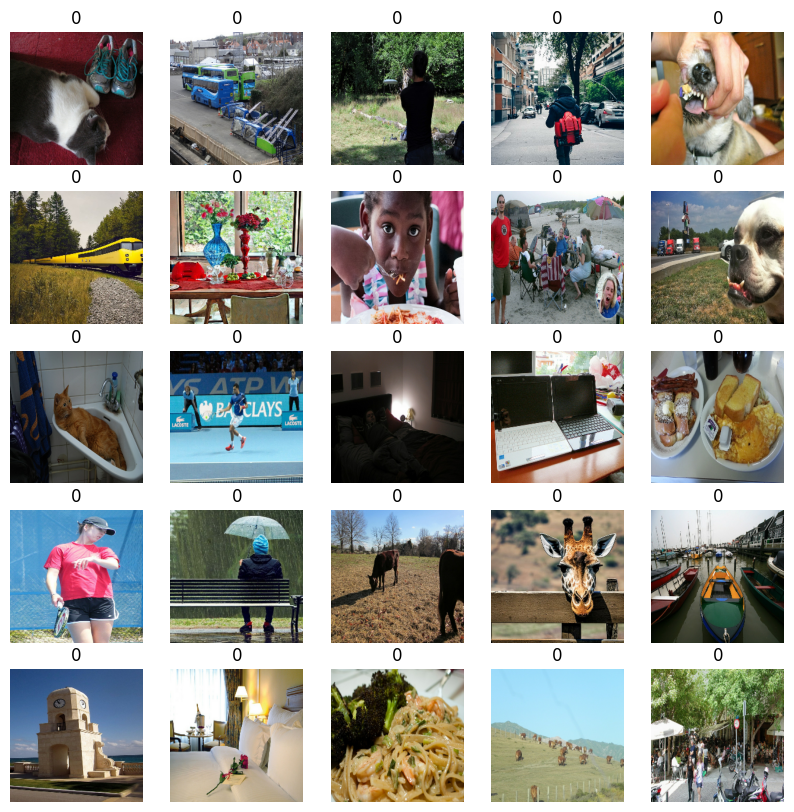

In [140]:
# visualizing
visualize_25_images(train_images, train_labels)

# Preparing the inputs and outputs of the model
  **We need to define a few things**
  * The `input` shape
  * The `output`shape
  * The URL of model we Want to use



In [141]:
# Building our deep-learning model using Transfer Learning rather thhan building from scratch for baseline results
# Before we proceed

INPUT_SHAPE = [None,IMG_SIZE,IMG_SIZE,3]
OUTPUT_SIZE = len(unique)
# url = "https://kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/130-224-classification/versions/1"


We will be using Tensorflow Keras deep learning model

Keras is the high-level API of the TensorFlow platform. It provides an approachable, highly-productive interface for solving machine learning (ML) problems, with a focus on modern deep learning. Keras covers every step of the machine learning workflow, from data processing to hyperparameter tuning to deployment. It was developed with a focus on enabling fast experimentation.

We have already defined a function
1. It takes ithe input and output shapes as a parameter
2. Define layers sequntially step by step
3. Compiles the model (Evaluate and improve)
4. Builds the model (Input shapes will be given)
5. Return Output

*Refer the documentation* https://www.tensorflow.org/guide/keras

For Transfer Learning but we aint using it in this project as its accuracy is not good

In [142]:
# def create_model(in_shape=INPUT_SHAPE,out_shape=OUTPUT_SIZE,mod_url=url):
#   print("Building Model this may take time ............")
#   print(f'Model url : {mod_url}')

#   #setup model layers
#   model = tf.keras.Sequential([
#       hub.KerasLayer(mod_url),# Layer 1(input layer)
#       tf.keras.layers.Dense(units=out_shape,
#                             activation="softmax")#layer 2 (output layer)
#   ])

#   #Compile the model
#   model.compile(
#       loss = tf.keras.losses.CategoricalFocalCrossentropy(),
#       optimizer = tf.keras.optimizers.Adam(),
#       metrics = ["accuracy"]
#   )

#   # Build the model
#   model.build(in_shape)

#   return model



In [143]:
# model = create_model()
# model.summary()

Steps in modelling for binary image classification with CNNs

* Becoming one with the data
* Preparing data for modelling
* Creating a CNN model (starting with a baseline)
* Fitting a model (getting it to find patterns in our data)
* Evaluating a model
* Improving a model
* Making a prediction with a trained model

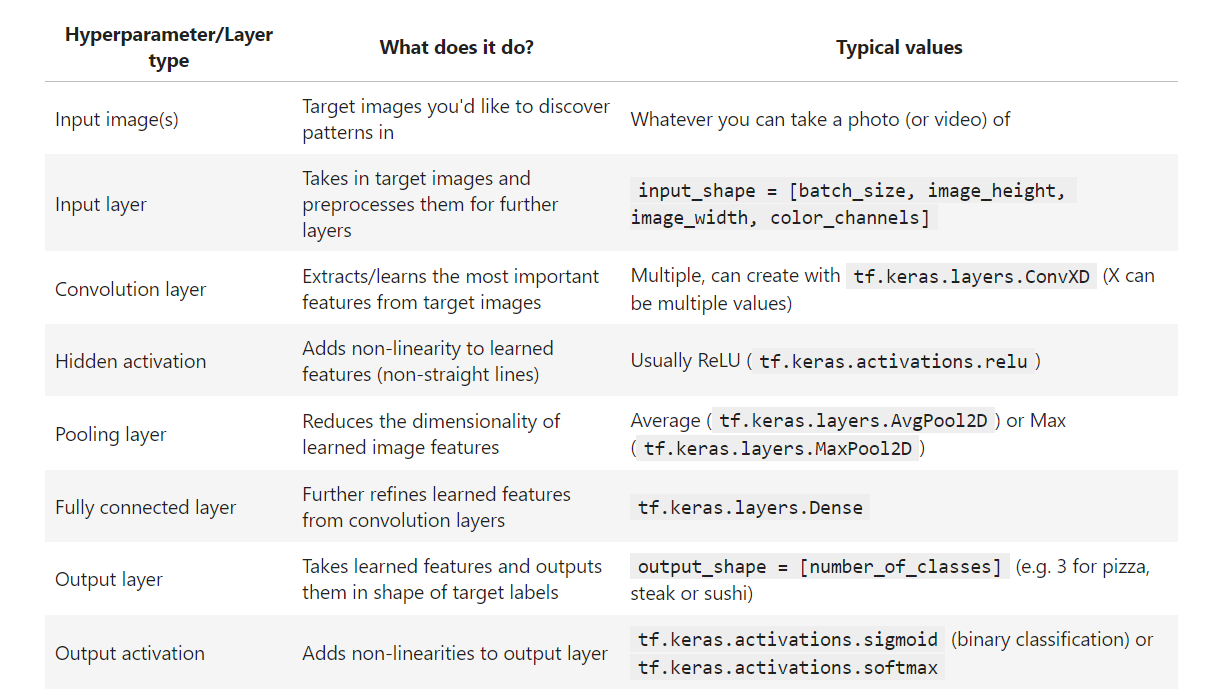

In [144]:
# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# # Setup the train and test directories
# train_dir = "pizza_steak/"
# test_dir = "pizza_steak/test/"

# Import data from directories and turn it into batches
# train_data = train_datagen.flow_from_directory(train_data,
#                                                batch_size=32, # number of images to process at a time
#                                                target_size=(224, 224), # convert all images to be 224 x 224
#                                                class_mode="binary", # type of problem we're working on
#                                                seed=42)

# valid_data = valid_datagen.flow_from_directory(Val_data,
#                                                batch_size=32,
#                                                target_size=(224, 224),
#                                                class_mode="binary",
#                                                seed=42)



In [145]:
# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)

# tf.random.set_seed(42)

# model_1 = tf.keras.models.Sequential([
#   tf.keras.layers.Conv2D(filters=10,
#                          kernel_size=3, # can also be (3, 3)
#                          activation="relu",
#                          input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
#   tf.keras.layers.BatchNormalization(),
#   tf.keras.layers.Conv2D(10, 3, activation="relu"),
#   tf.keras.layers.BatchNormalization(),
#   tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
#                             padding="valid"), # padding can also be 'same'
#   tf.keras.layers.Conv2D(10, 3, activation="relu"),
#   tf.keras.layers.BatchNormalization(),
#   tf.keras.layers.BatchNormalization(),#added without them its 100 % and 51%
#   tf.keras.layers.Conv2D(10, 3, activation="relu"),#added
#   tf.keras.layers.BatchNormalization(), # added
#   tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
#   tf.keras.layers.BatchNormalization(),
#   tf.keras.layers.MaxPool2D(2),
#   tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
#]) #  taining accuracy 100%, validation accuracy52%



# model_1 = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(filters=10,
#                            kernel_size=3,
#                            activation="relu",
#                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  # Add L2 regularization
#                            input_shape=(224, 224, 3)),
#     tf.keras.layers.Conv2D(10, 3, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
#     tf.keras.layers.Conv2D(10, 3, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     tf.keras.layers.Conv2D(10, 3, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     tf.keras.layers.MaxPool2D(2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(1, activation="sigmoid")
# ]) # 98%,49%,31000 params with regularization


# model_1 = tf.keras.Sequential([
#   tf.keras.layers.Flatten(input_shape=(224, 224, 3)), # dense layers expect a 1-dimensional vector as input
#   tf.keras.layers.Dense(100, activation='relu'), # increase number of neurons from 4 to 100 (for each layer)
#   tf.keras.layers.Dense(100, activation='relu'),
#   # tf.keras.layers.Dense(100, activation='relu'), # add an extra layer 15cr
#   tf.keras.layers.Dense(1, activation='sigmoid')
# ]) #67%,50% 1.5cr


In [146]:
# Define the model with increased dropout rate
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation="relu",
                           input_shape=(224, 224, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),  # Increase dropout rate to 0.5
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Define EarlyStopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
) #slow and 77% ,56% accuracy



In [147]:
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=25,
                        steps_per_epoch=len(train_data),
                        validation_data=Val_data,
                        validation_steps=len(Val_data))

Epoch 1/25
500/500 [==============================] - 681s 1s/step - loss: 0.8831 - accuracy: 0.7336 - val_loss: 0.9669 - val_accuracy: 0.6980
Epoch 2/25
500/500 [==============================] - 681s 1s/step - loss: 0.6273 - accuracy: 0.7825 - val_loss: 0.5257 - val_accuracy: 0.7688
Epoch 3/25
500/500 [==============================] - 684s 1s/step - loss: 0.4517 - accuracy: 0.8179 - val_loss: 0.3849 - val_accuracy: 0.8315
Epoch 4/25
500/500 [==============================] - 697s 1s/step - loss: 0.3614 - accuracy: 0.8459 - val_loss: 0.4693 - val_accuracy: 0.7993
Epoch 5/25
500/500 [==============================] - 681s 1s/step - loss: 0.3229 - accuracy: 0.8614 - val_loss: 0.6694 - val_accuracy: 0.7412
Epoch 6/25
500/500 [==============================] - 697s 1s/step - loss: 0.2912 - accuracy: 0.8701 - val_loss: 0.4079 - val_accuracy: 0.8322
Epoch 7/25
500/500 [==============================] - 686s 1s/step - loss: 0.2776 - accuracy: 0.8779 - val_loss: 0.3849 - val_accuracy: 0.8288

In [155]:
model_1.save('C://Users/Shreyas/Desktop/Deepfake/my_model_1.h5')
# load_model()

In [156]:
model_1.save('C://Users/Shreyas/Desktop/Deepfake/my_model_1.keras')

In [157]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 batch_normalization_6 (Bat  (None, 222, 222, 10)      40        
 chNormalization)                                                
                                                                 
 conv2d_6 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 batch_normalization_7 (Bat  (None, 220, 220, 10)      40        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 110, 110, 10)      0         
 g2D)                                                            
                                                      

# Loading the model


In [162]:
model = load_model('C://Users/Shreyas/Desktop/Deepfake/my_model_1.keras')

## Testing

In [159]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

1/1 [==============================] - 0s 31ms/step


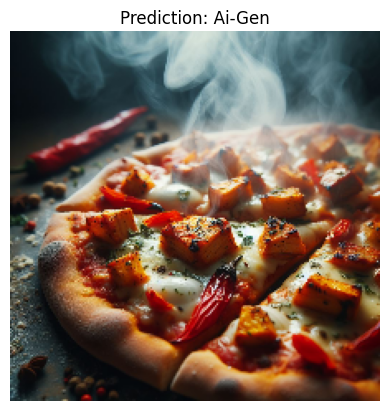

In [189]:
class_names = ['Ai-Gen','Real']
pred_and_plot(model,"C://Users/Shreyas/Downloads/Designer.png", class_names)
pred_and_plot(model,"C://Users/Shreyas/Downloads/balls.png", class_names)